Main hypothesis: Banks (morgages) fuel house price increase

Exploring: the feedback loop between credit expansion, inequality, and housing prices with an emphasis on whether rising mortgage volumes reflect not just inflation but changing financial behavior and structural inequality

Over time, loans have increased, not only due to inflation?
1. Idea: Banks are doing bigger risks because they can just own the property after the borrower defaults -> taking away resources -> bigger battle for resources -> price increase -> loans increase because wages didn’t increase
-> Formulate a relationship between morgages, inequality and housing price

Key Variables:

- Housing Prices
- Mortgage Credit
- Interes Rates
- Wages/Income
- Inequality
- Inflation
- Housing Supply


Real House Price = nominal house price / CPI
Real Mortgage Credit = mortgage credit / CPI
Mortgage-to-Income Ratio = total mortgage credit / disposable personal income
Debt-Service Ratio = mortgage payments / income
Housing Affordability Index = function of income, rates, and home prices

In [25]:
import pandas as pd
from pathlib import Path

data_path = Path("data")

# Read the 'Monthly' sheet from the median_house_price file
prices = pd.read_excel(data_path / "median_house_price.xlsx", sheet_name="Monthly")
# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(prices["observation_date"]):
    prices["observation_date"] = pd.to_datetime(prices["observation_date"])

prices.set_axis(prices["observation_date"])  # index by date
# Read CPI file and parse dates; adjust column name if different
cpi_data = pd.read_excel(
    data_path / "cpi.xlsx",
    sheet_name="Monthly",
    parse_dates=["observation_date"]  # ensure this is the actual date column name
)

# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(cpi_data["observation_date"]):
    cpi_data["observation_date"] = pd.to_datetime(cpi_data["observation_date"])

# Filter CPI data to start from 1963-01-01 (inclusive)
cpi_data = cpi_data[cpi_data["observation_date"] >= "1963-01-01"]

# Extract CPI series (column named 'cpi' in the Excel file)
cpi = cpi_data["cpi"]

# Optional: reset index or keep dates as index
cpi = cpi.set_axis(cpi_data["observation_date"])  # index by date if desired

# Quick check
print(cpi.head())
print(f"Rows after filtering: {len(cpi)}")

observation_date
1963-01-01    30.44
1963-02-01    30.48
1963-03-01    30.51
1963-04-01    30.48
1963-05-01    30.51
Name: cpi, dtype: float64
Rows after filtering: 752


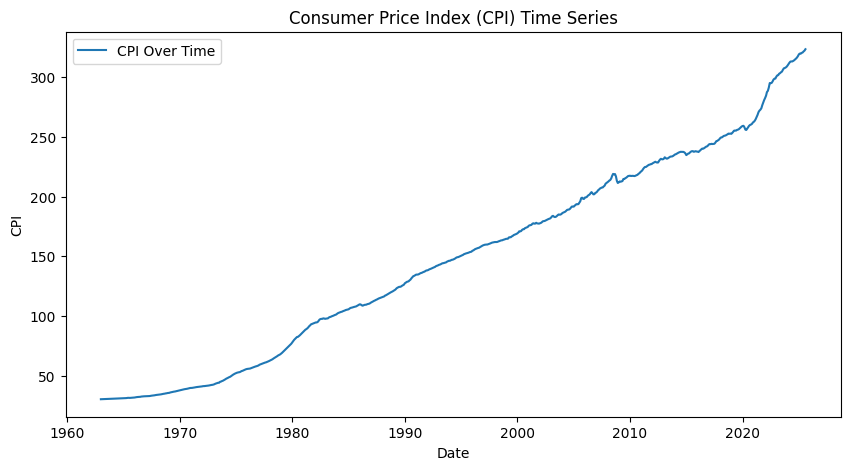

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(cpi.index, cpi.values, label='CPI Over Time')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Consumer Price Index (CPI) Time Series')
plt.legend()
plt.show()



<Figure size 640x480 with 0 Axes>

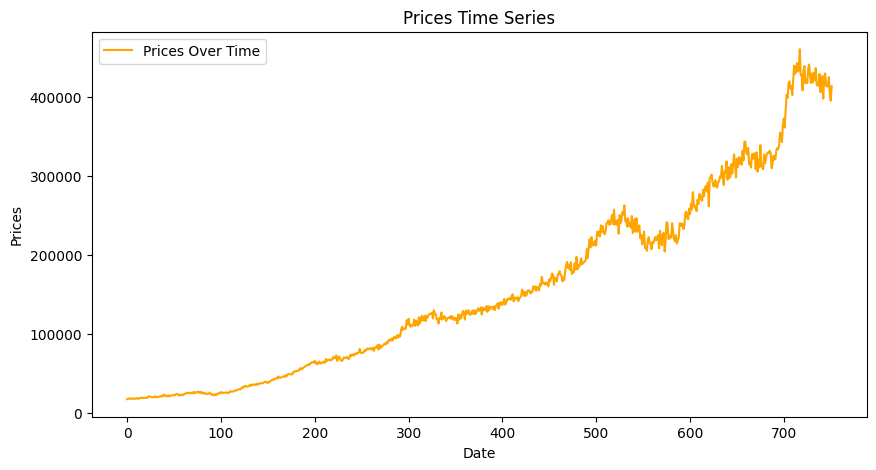

In [27]:
# clear last plot
plt.clf()
# plot nominal prices
plt.figure(figsize=(10, 5))
plt.plot(prices.index, prices.price, label='Prices Over Time', color='orange')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title('Prices Time Series')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

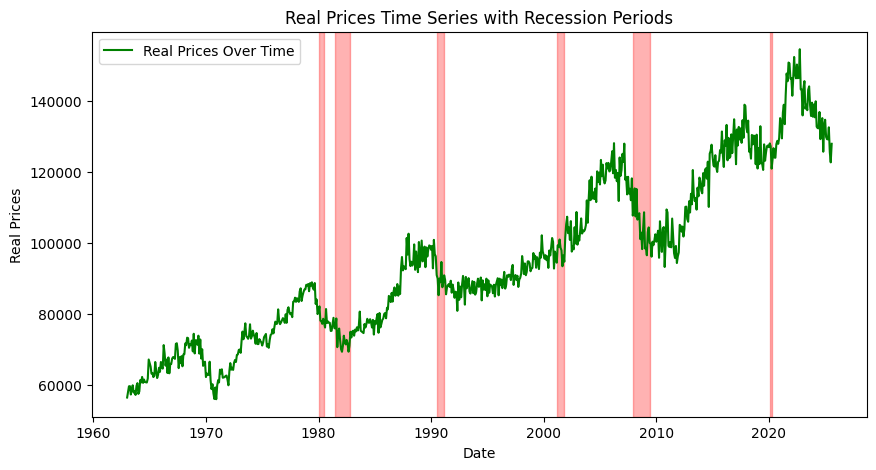

In [ ]:

cpi_100 = cpi / 100

real_prices = prices.price.values / cpi_100.values  # Align CPI to prices index

# plot recession periods
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(prices.observation_date, real_prices, label='Real Prices Over Time',color='green')
# Highlight recession periods
recession_periods = [
    ("1980-01-01", "1980-07-01"),  # Early 1980s recession
    ("1981-07-01", "1982-11-01"),  # Double-dip recession
    ("1990-07-01", "1991-03-01"),  # Early 1990s recession
    ("2001-03-01", "2001-11-01"),  # Dot-com recession
    ("2007-12-01", "2009-06-01"),  # Great Recession
    ("2020-02-01", "2020-04-01")   # COVID-19 recession
]
for start, end in recession_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.3) # Highlight recession periods
plt.xlabel('Date')
plt.ylabel('Real Prices')
plt.title('Real Prices Time Series with Recession Periods')
plt.legend()
plt.show()  

In [29]:
# log transform
import numpy as np
log_real_prices = np.log(real_prices)
# INDEX BY OBSERVATION DATE
log_real_prices = pd.Series(log_real_prices, index=prices.observation_date)

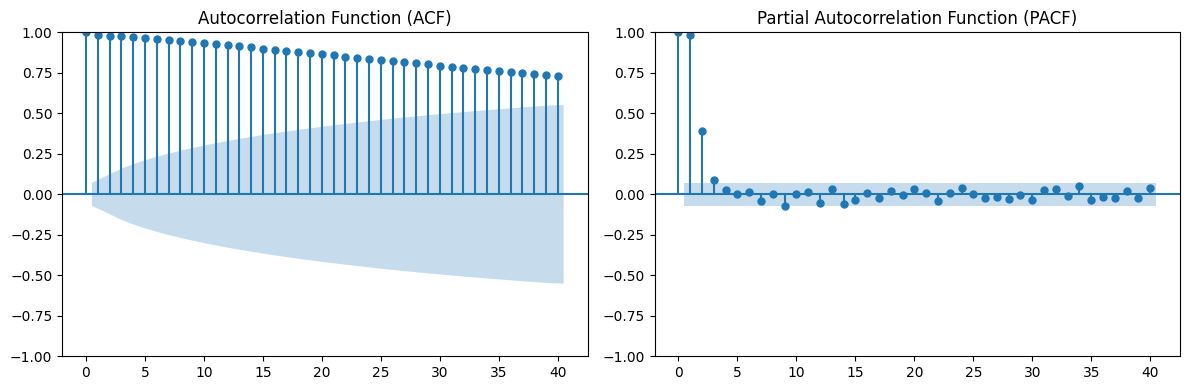

ADF Statistic: -1.4670607428141176
p-value: 0.5497384698110896
Critical Value (1%): -3.439
Critical Value (5%): -2.866
Critical Value (10%): -2.569
ADF Statistic (differenced): -5.586640585840968
p-value (differenced): 1.358237299554451e-06
Critical Value (1%): -3.439
Critical Value (5%): -2.866
Critical Value (10%): -2.569


In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Basic ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(log_real_prices, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(log_real_prices, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# check stationarity with ADF test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(log_real_prices)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))
    
# difference prices to make it stationary
log_real_prices_diff = pd.Series(log_real_prices).diff().dropna()
adf_result_diff = adfuller(log_real_prices_diff)
print('ADF Statistic (differenced):', adf_result_diff[0])
print('p-value (differenced):', adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

It's not stationary, so it needs to be differenced. After Differencing it becomes stationary

In [31]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(p, d, q) where:
# p = AR lags (2 in your case)
# d = differencing order (0 if your data is already stationary)
# q = MA terms (0 for no MA)

model = ARIMA(log_real_prices, order=(3, 0, 0))
results = model.fit()

# View results
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  752
Model:                 ARIMA(3, 0, 0)   Log Likelihood                1510.747
Date:                Tue, 18 Nov 2025   AIC                          -3011.494
Time:                        11:55:01   BIC                          -2988.380
Sample:                    01-01-1963   HQIC                         -3002.588
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3884      0.174     65.586      0.000      11.048      11.729
ar.L1          0.4214      0.035     12.118      0.000       0.353       0.490
ar.L2          0.3997      0.033     12.042      0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


const     11.388381
ar.L1      0.421357
ar.L2      0.399728
ar.L3      0.174965
sigma2     0.001057
dtype: float64


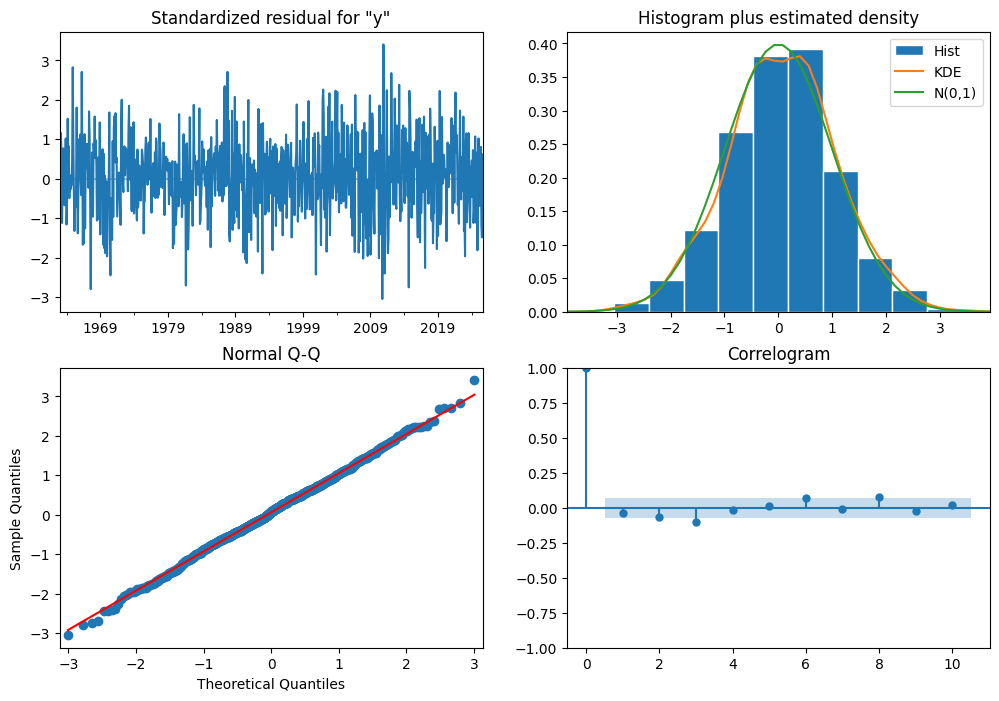

In [32]:
# Fitted values
fitted_values = results.fittedvalues

# Residuals
residuals = results.resid

# Forecasting
forecast = results.forecast(steps=10)

# Model parameters
print(results.params)

# Plot diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

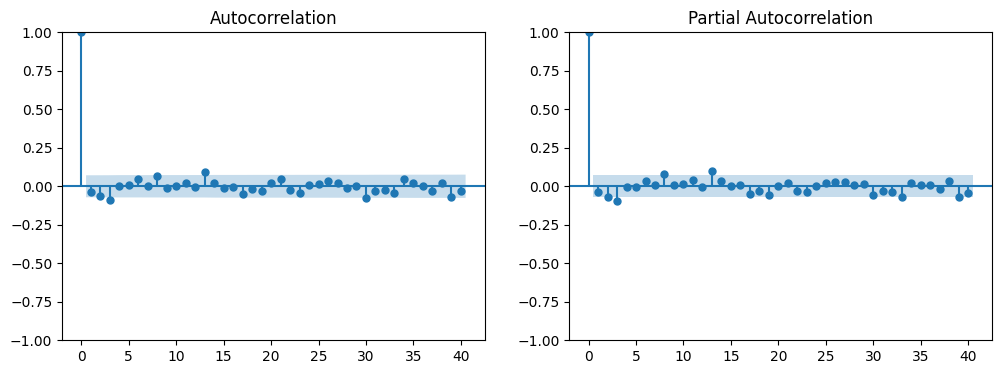

In [33]:
# After fitting a model
residuals = results.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, lags=40, ax=axes[0])
plot_pacf(residuals, lags=40, ax=axes[1])
plt.show()

Mean Squared Error of BENCHMARK (MSE_benchmark): 0.0013082809374746283


<Figure size 640x480 with 0 Axes>

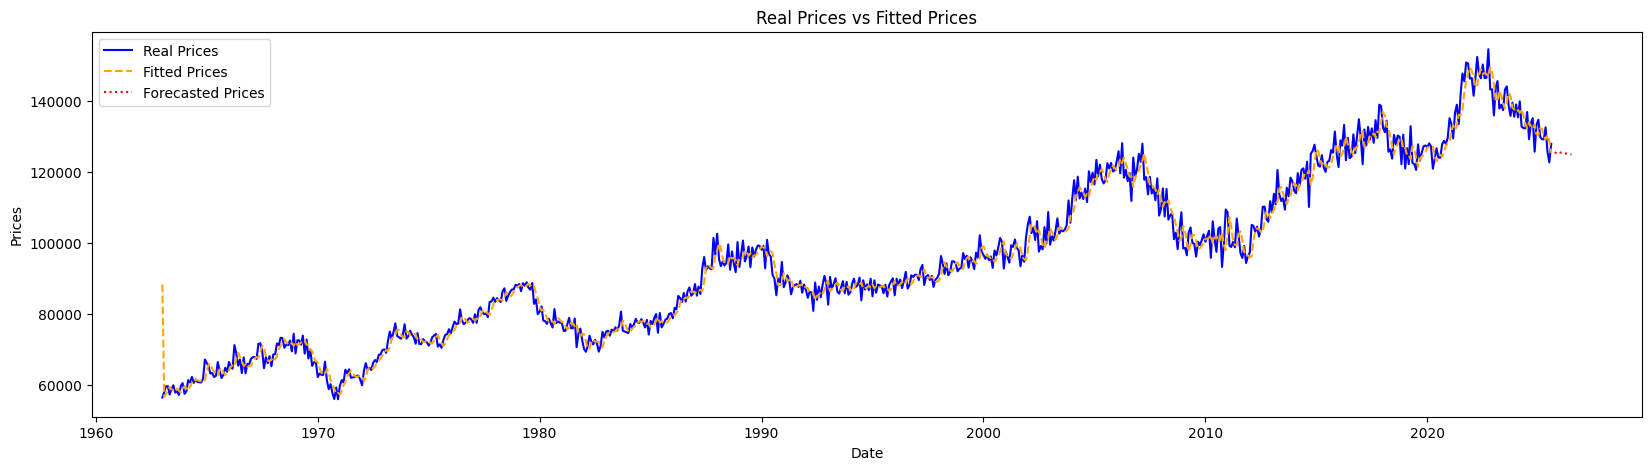

In [34]:
# calculate the MSE
from sklearn.metrics import mean_squared_error
mse_benchmark = mean_squared_error(log_real_prices, fitted_values)
print(f'Mean Squared Error of BENCHMARK (MSE_benchmark): {mse_benchmark}')
# level the predictions
leveled_fitted_values = np.exp(fitted_values)
forecast_leveled = np.exp(forecast)


# plot predictions vs real values and add forecasted values
plt.clf()
plt.figure(figsize=(20, 5))
plt.plot(prices.observation_date, real_prices, label='Real Prices', color='blue')
plt.plot(prices.observation_date, leveled_fitted_values, label='Fitted Prices', color='orange', linestyle='--')
plt.plot(pd.date_range(start=prices.observation_date.iloc[-1], periods=11, freq='ME')[1:], forecast_leveled, label='Forecasted Prices', color='red', linestyle=':')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title('Real Prices vs Fitted Prices')
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

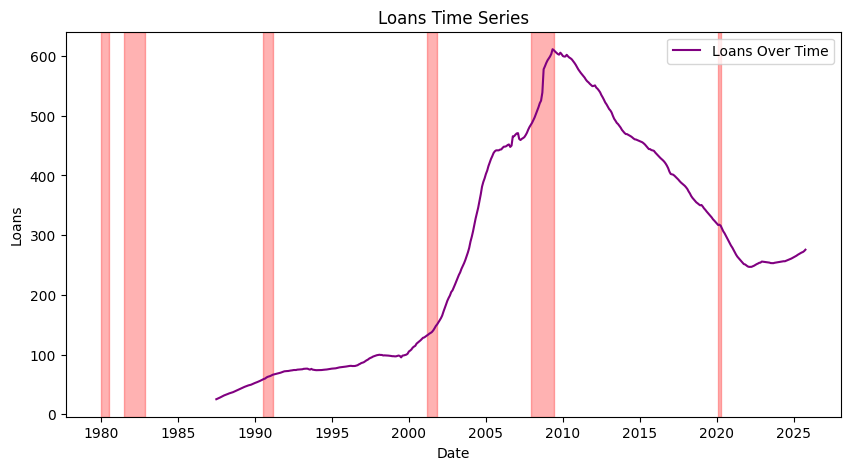

In [35]:
# import loans data
loans = pd.read_excel(data_path / "loans.xlsx", sheet_name="Monthly")
# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(loans["observation_date"]):
    loans["observation_date"] = pd.to_datetime(loans["observation_date"])
    
# set index to date
loans.set_index("observation_date", inplace=True)  # index by date

# plot loans data
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(loans.index, loans.loans, label='Loans Over Time', color='purple')
plt.xlabel('Date')
plt.ylabel('Loans')
plt.title('Loans Time Series')

recession_periods = [
    ("1980-01-01", "1980-07-01"),  # Early 1980s recession
    ("1981-07-01", "1982-11-01"),  # Double-dip recession
    ("1990-07-01", "1991-03-01"),  # Early 1990s recession
    ("2001-03-01", "2001-11-01"),  # Dot-com recession
    ("2007-12-01", "2009-06-01"),  # Great Recession
    ("2020-02-01", "2020-04-01")   # COVID-19 recession
]
for start, end in recession_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.3)

plt.legend()
plt.show()

In [36]:
# create VAR model with loans and real prices
from statsmodels.tsa.api import VAR
# Combine loans and real prices into a single DataFrame
data_combined = pd.DataFrame({
    'real_prices': real_prices,
    'loans': loans.loans.reindex(prices.observation_date)  # Align loans to prices index
})
data_combined = data_combined.dropna()
# use var 3 model

results = VAR(data_combined).fit(maxlags=3, ic='aic')
# align fitted to data_combined: fittedvalues covers data_combined.index[results.k_ar:]
fitted_df = pd.DataFrame(results.fittedvalues,
                         index=data_combined.index[results.k_ar:],
                         columns=data_combined.columns)
print(results.summary())
# predict next 20 periods
forecast = results.forecast(steps=20, y=data_combined.values[-results.k_ar:])
print("Forecasted values for the next 20 periods:")
print(forecast)



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Nov, 2025
Time:                     11:55:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    18.3801
Nobs:                     455.000    HQIC:                   18.3033
Log likelihood:          -5429.86    FPE:                8.45888e+07
AIC:                      18.2533    Det(Omega_mle):     8.20450e+07
--------------------------------------------------------------------
Results for equation real_prices
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const               1666.131699      1184.772933            1.406           0.160
L1.real_prices         0.361654         0.046481            7.781           0.000
L1.loans             -13.198962        72.902500  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Based on the Augmented Dickey-Fuller test the series is Non-stationary
the p-value is very high
The null hypothesis of a unit root is rejected

Overall Model Fit
The model includes 2 equations with 3 lags each, estimated on 455 observations. The information criteria (AIC=18.25, BIC=18.38) are useful for comparing alternative lag structures—lower values indicate better fit.
Equation 1: Real Prices
Key findings:

Past prices matter a lot: All three lags of real_prices are highly significant (p < 0.001), with coefficients of 0.36, 0.42, and 0.20. This means prices exhibit strong persistence—past values help predict current values.
Loans don't predict prices: None of the loan lags are significant (all p > 0.6). This suggests loans don't have a meaningful causal effect on real prices in this model.
Sum of coefficients: Adding the price lags gives 0.98, suggesting near-unit-root behavior (prices are highly persistent but stationary).

Equation 2: Loans
Key findings:

Loans are highly autocorrelated: L1.loans has a coefficient of 1.56 (t=33.8, p<0.001), and L2 and L3 are also significant. This strong persistence suggests loans grow over time.
Prices weakly predict loans: L1.real_prices shows marginal significance (p=0.086) with a tiny negative coefficient (-0.00005). This suggests higher prices might slightly reduce loan growth, but the effect is economically small.
Dynamic structure: The loan coefficients (1.56, -0.33, -0.23) sum to about 0.98, again indicating high persistence.

Cross-Variable Relationships
The lack of significant cross-effects (loans → prices) and weak effects (prices → loans) suggest these variables evolve somewhat independently. The correlation of residuals is small (-0.09), confirming weak contemporaneous relationships.
Practical Implications

Prices and loans both follow their own autoregressive patterns
There's little evidence of Granger causality from loans to prices
Weak evidence that prices might Granger-cause loans (test this formally with a Granger causality test)
Consider checking if your data needs differencing if you suspect non-stationarity

<Figure size 640x480 with 0 Axes>

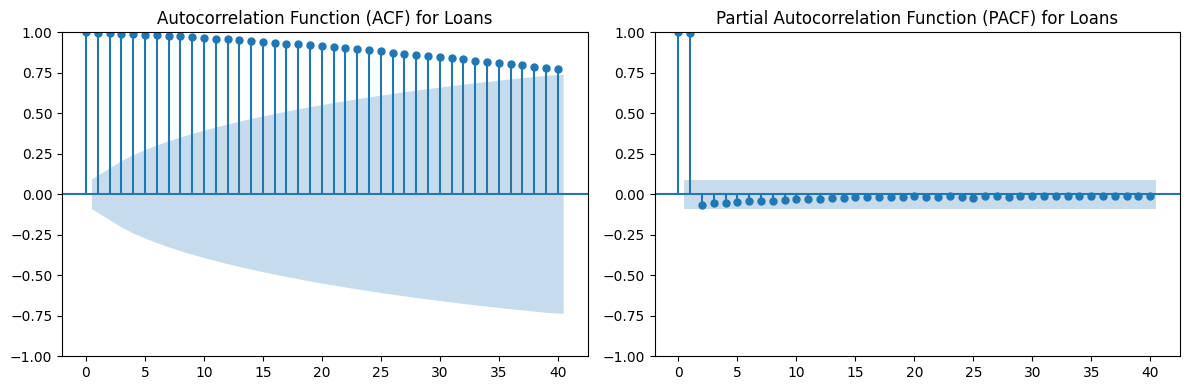

ADF Statistic: -1.6441507123040802
p-value: 0.46009275799527866
Critical Value (1%): -3.445
Critical Value (5%): -2.868
Critical Value (10%): -2.570


In [37]:
# plot ACF and PACF for loans
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(loans.loans.dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) for Loans')
plot_pacf(loans.loans.dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) for Loans')
plt.tight_layout()
plt.show()

# check loans for stationarity with ADF test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(loans.loans.dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))
    

In [38]:
# difference loans to make it stationary
loans_diff = loans.loans.diff().dropna()
adf_result_diff = adfuller(loans_diff)
print('ADF Statistic (differenced):', adf_result_diff[0])
print('p-value (differenced):', adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print('Critical Value (%s): %.3f' % (key, value))
    
    

ADF Statistic (differenced): -2.861669404660905
p-value (differenced): 0.049990340078595846
Critical Value (1%): -3.445
Critical Value (5%): -2.868
Critical Value (10%): -2.570


In [39]:
# redo the VAR model with differenced loans
log_real_prices_diff = pd.Series(log_real_prices).diff().dropna()
data_combined_diff = pd.DataFrame({
    'real_prices_diff': log_real_prices_diff,
    'loans_diff': loans_diff.reindex(prices.observation_date)  # Align loans to prices index
})
data_combined_diff = data_combined_diff.dropna()
# use var 3 model
results = VAR(data_combined_diff).fit(maxlags=15, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Nov, 2025
Time:                     11:55:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.70333
Nobs:                     446.000    HQIC:                  -4.95949
Log likelihood:          -76.5441    FPE:                 0.00594000
AIC:                     -5.12623    Det(Omega_mle):      0.00537169
--------------------------------------------------------------------
Results for equation real_prices_diff
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.001337         0.001603            0.834           0.404
L1.real_prices_diff         -0.680885         0.048143          -14.143           0.000
L1.loans_diff        

Mean Squared Error (MSE) for VAR model: 2.403115086549053


<Figure size 640x480 with 0 Axes>

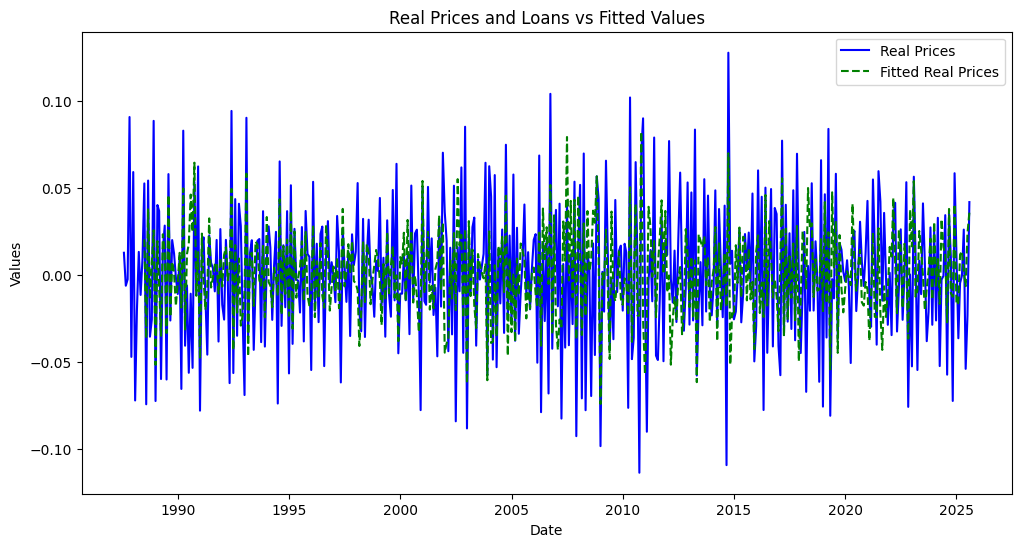

In [40]:
# calculate MSE for VAR model
from sklearn.metrics import mean_squared_error
fitted_values = results.fittedvalues


# ensure fitted_values is a DataFrame
if not isinstance(fitted_values, pd.DataFrame):
    fitted_values = pd.DataFrame(fitted_values, columns=data_combined_diff.columns)

expected_index = data_combined_diff.index[results.k_ar:]

# trim/align lengths if necessary
if len(fitted_values) > len(expected_index):
    fitted_values = fitted_values.iloc[-len(expected_index):].reset_index(drop=True)
elif len(fitted_values) < len(expected_index):
    expected_index = expected_index[-len(fitted_values):]

fitted_values.index = expected_index
fitted_values.columns = data_combined_diff.columns

# drop the first value before computing MSE
mse_var = mean_squared_error(
    data_combined_diff.values[12:],
    fitted_values.iloc[1:].values
)
print(f'Mean Squared Error (MSE) for VAR model: {mse_var}')

# plot real prices and loans with fitted values
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(data_combined_diff.index, data_combined_diff['real_prices_diff'], label='Real Prices', color='blue')
plt.plot(fitted_values.index, fitted_values['real_prices_diff'], label='Fitted Real Prices', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Real Prices and Loans vs Fitted Values')
plt.legend()
plt.show()



<Figure size 640x480 with 0 Axes>

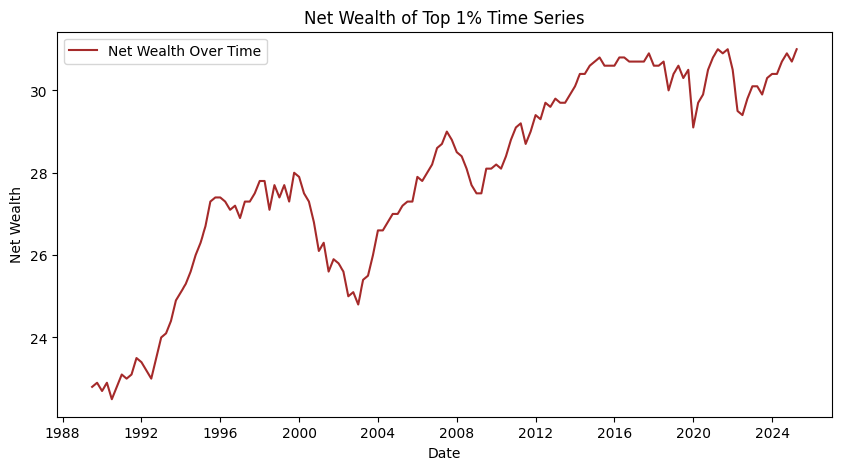

In [41]:
# read net_wealth data
net_wealth = pd.read_excel(data_path / "net_wealth_of_top_1.xlsx", sheet_name="Quarterly")
# trabsform to monthly with linear interpolation
net_wealth.set_index("observation_date", inplace=True)
# net_wealth rename percentage column to 'net_wealth
net_wealth.rename(columns={"percentage": "net_wealth"}, inplace=True)

net_wealth_monthly = net_wealth.resample('MS').interpolate(method='linear').ffill().bfill()


# plot monthly net wealth
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(net_wealth_monthly.index, net_wealth_monthly.net_wealth, label='Net Wealth Over Time', color='brown')
plt.xlabel('Date')
plt.ylabel('Net Wealth')
plt.title('Net Wealth of Top 1% Time Series')
plt.legend()
plt.show()


In [42]:
# create VAR model with net wealth, loans and real prices


<Figure size 640x480 with 0 Axes>

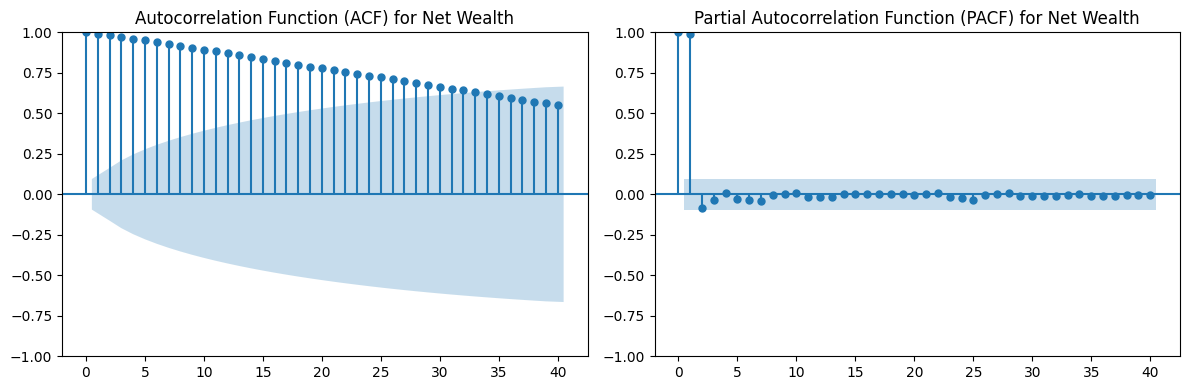

ADF Statistic: -1.8303118215062593
p-value: 0.3655199113566299
Critical Value (1%): -3.446
Critical Value (5%): -2.869
Critical Value (10%): -2.571
ADF Statistic (differenced): -4.153451550684587
p-value (differenced): 0.0007891984398435163
Critical Value (1%): -3.446
Critical Value (5%): -2.869
Critical Value (10%): -2.571


In [43]:
# plot ACF and PACF for net wealth
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(net_wealth_monthly.net_wealth.dropna(), lags=40,
            ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) for Net Wealth')
plot_pacf(net_wealth_monthly.net_wealth.dropna(), lags=40,
            ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) for Net Wealth')
plt.tight_layout()
plt.show()

# check for dickiey-fuller test for net wealth
from statsmodels.tsa.stattools import adfuller
adf_result_nw = adfuller(net_wealth_monthly.net_wealth.dropna())
print('ADF Statistic:', adf_result_nw[0])
print('p-value:', adf_result_nw[1])
for key, value in adf_result_nw[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

# check net wealth for stationarity with ADF test
net_wealth_diff = net_wealth_monthly.net_wealth.diff().dropna()
adf_result_nw = adfuller(net_wealth_diff)
print('ADF Statistic (differenced):', adf_result_nw[0])
print('p-value (differenced):', adf_result_nw[1])
for key, value in adf_result_nw[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

In [44]:
# redo the VAR model with net wealth
log_real_prices_diff = pd.Series(log_real_prices).diff().dropna()
data_combined_diff = pd.DataFrame({
    'real_prices_diff': log_real_prices_diff,
    'net_wealth_diff': net_wealth_diff.reindex(prices.observation_date)  # Align net wealth to prices index
})
data_combined_diff = data_combined_diff.dropna()
# use var 3 model
results = VAR(data_combined_diff).fit(maxlags=15, ic='aic')
print(results.summary())

print(results.k_ar)        # lag order
print(results.names)       # variable names
print(results.endog.shape) # rows used, variables   

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Nov, 2025
Time:                     11:55:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.4694
Nobs:                     414.000    HQIC:                  -11.8338
Log likelihood:           1386.08    FPE:                5.71909e-06
AIC:                     -12.0723    Det(Omega_mle):     4.95003e-06
--------------------------------------------------------------------
Results for equation real_prices_diff
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000757         0.001707            0.443           0.657
L1.real_prices_diff         -0.720462         0.050503          -14.266           0.000
L1.net_wealth_diff   

Mean Squared Error (MSE) for VAR model: 0.0026637605701619843


<Figure size 640x480 with 0 Axes>

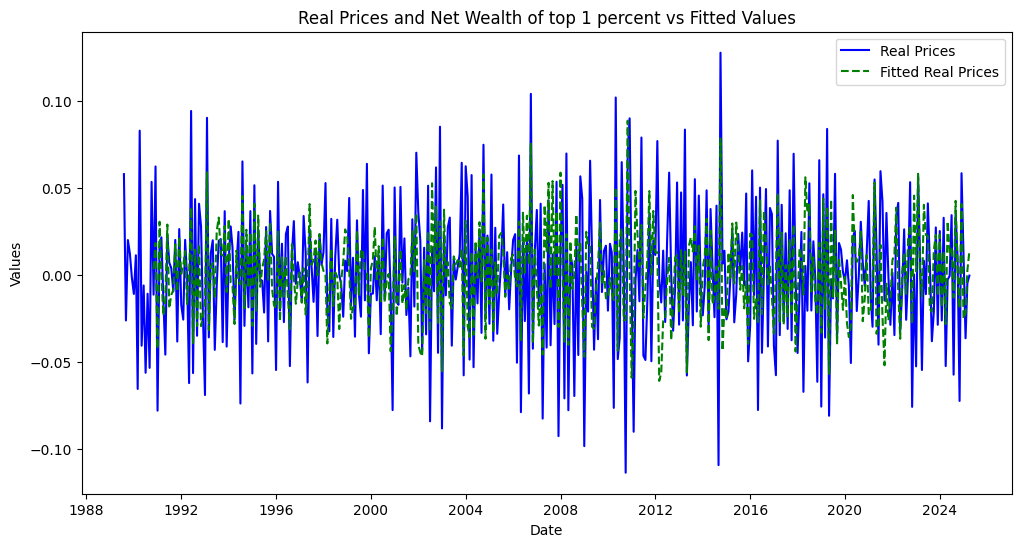

In [45]:
# calculate MSE for VAR model
from sklearn.metrics import mean_squared_error
fitted_values = results.fittedvalues


# ensure fitted_values is a DataFrame
if not isinstance(fitted_values, pd.DataFrame):
    fitted_values = pd.DataFrame(fitted_values, columns=data_combined_diff.columns)

expected_index = data_combined_diff.index[results.k_ar:]

# trim/align lengths if necessary
if len(fitted_values) > len(expected_index):
    fitted_values = fitted_values.iloc[-len(expected_index):].reset_index(drop=True)
elif len(fitted_values) < len(expected_index):
    expected_index = expected_index[-len(fitted_values):]

fitted_values.index = expected_index
fitted_values.columns = data_combined_diff.columns

# drop the first value before computing MSE
mse_var_net_wealth = mean_squared_error(
    data_combined_diff.values[16:],
    fitted_values.iloc[1:].values
)
print(f'Mean Squared Error (MSE) for VAR model: {mse_var_net_wealth}')

# plot real prices and loans with fitted values
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(data_combined_diff.index, data_combined_diff['real_prices_diff'], label='Real Prices', color='blue')
plt.plot(fitted_values.index, fitted_values['real_prices_diff'], label='Fitted Real Prices', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Real Prices and Net Wealth of top 1 percent vs Fitted Values')
plt.legend()
plt.show()


In [46]:
model = VAR(data_combined_diff).select_order(maxlags=15)
print(model.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.78      -10.76   2.082e-05      -10.77
1       -11.67      -11.62   8.514e-06      -11.65
2       -11.75      -11.65   7.889e-06      -11.71
3       -11.84      -11.70   7.237e-06      -11.78
4       -12.06     -11.88*   5.814e-06     -11.99*
5       -12.07      -11.85   5.752e-06      -11.98
6       -12.06      -11.81   5.795e-06      -11.96
7       -12.07      -11.78   5.743e-06      -11.95
8       -12.06      -11.73   5.799e-06      -11.93
9       -12.06      -11.69   5.802e-06      -11.91
10      -12.06      -11.65   5.808e-06      -11.89
11      -12.06      -11.62   5.765e-06      -11.89
12      -12.06      -11.57   5.807e-06      -11.86
13      -12.07      -11.55   5.725e-06      -11.86
14      -12.07      -11.50   5.756e-06      -11.84
15     -12.07*      -11.47  5.719e-06*      -11.83
-------------------------------

In [47]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
cj = coint_johansen(data_combined_diff[['real_prices_diff', 'net_wealth_diff']], det_order=0, k_ar_diff=5)


In [48]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(data_combined_diff[['real_prices_diff','net_wealth_diff']], maxlag=12)
    


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3508  , p=0.1260  , df_denom=425, df_num=1
ssr based chi2 test:   chi2=2.3674  , p=0.1239  , df=1
likelihood ratio test: chi2=2.3609  , p=0.1244  , df=1
parameter F test:         F=2.3508  , p=0.1260  , df_denom=425, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5096  , p=0.0115  , df_denom=422, df_num=2
ssr based chi2 test:   chi2=9.1261  , p=0.0104  , df=2
likelihood ratio test: chi2=9.0299  , p=0.0109  , df=2
parameter F test:         F=4.5096  , p=0.0115  , df_denom=422, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3787  , p=0.0183  , df_denom=419, df_num=3
ssr based chi2 test:   chi2=10.3056 , p=0.0161  , df=3
likelihood ratio test: chi2=10.1829 , p=0.0171  , df=3
parameter F test:         F=3.3787  , p=0.0183  , df_denom=419, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5673  , p=0.0377  

{np.int64(1): ({'ssr_ftest': (np.float64(2.3508220668917583),
    np.float64(0.1259609945569274),
    np.float64(425.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(2.3674161050109945),
    np.float64(0.12389196508877307),
    np.int64(1)),
   'lrtest': (np.float64(2.3608926507613432),
    np.float64(0.12441098094855933),
    np.int64(1)),
   'params_ftest': (np.float64(2.3508220668917277),
    np.float64(0.1259609945569274),
    np.float64(425.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(4.509594875247599),
    np.float64(0.011538337881024466),
    np.float64(422.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(9.126052188297272),
    np.float64(0.010430447621616105),
    np.int64(2)),
   'lrtest': (np.float64(9.029896613063556),
    np.float64(0.010944170854357527),
    np.int64(2)),
   'params_ftest': (np.float64(4.509594875247611),
    np.float64(0.01153833788102419),
    np.float64(422.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
 

<Figure size 640x480 with 0 Axes>

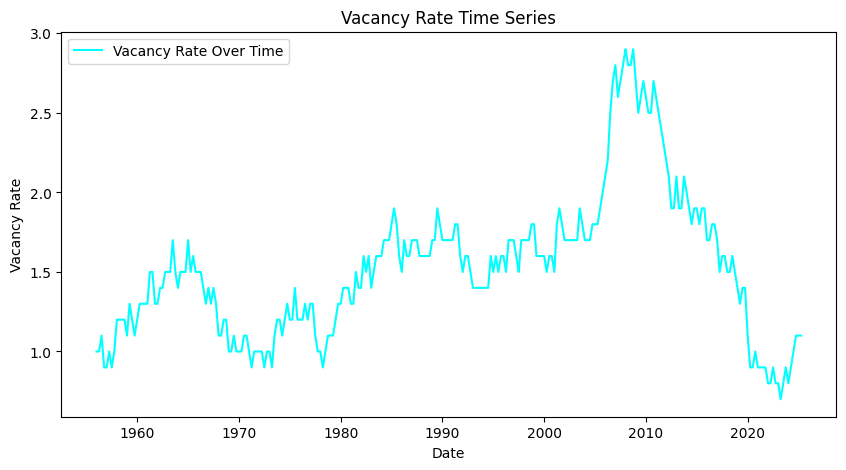

ADF Statistic (differenced): -4.37495465284779
p-value (differenced): 0.0003286376272039912
Critical Value (1%): -3.438
Critical Value (5%): -2.865
Critical Value (10%): -2.569
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Nov, 2025
Time:                     11:55:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.2364
Nobs:                     733.000    HQIC:                  -14.4598
Log likelihood:           3328.78    FPE:                4.56339e-07
AIC:                     -14.6001    Det(Omega_mle):     4.22265e-07
--------------------------------------------------------------------
Results for equation real_prices_diff
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const             

In [49]:
# import vacancy_rate data
vacancy_rate = pd.read_excel(data_path / "vacancy_rate.xlsx", sheet_name="Quarterly")
vacancy_rate = vacancy_rate.set_index("observation_date")
vacancy_rate_monthly = vacancy_rate.resample('MS').interpolate(method='linear').ffill().bfill()

# plot vacancy rate
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(vacancy_rate_monthly.index, vacancy_rate_monthly.vacancy_rate, label='Vacancy Rate Over Time', color='cyan')
plt.xlabel('Date')      
plt.ylabel('Vacancy Rate')
plt.title('Vacancy Rate Time Series')
plt.legend()
plt.show()
# difference vacancy rate to make it stationary
vacancy_rate_monthly_diff = vacancy_rate_monthly.diff().dropna()
adf_result_vr = adfuller(vacancy_rate_monthly_diff.vacancy_rate)
print('ADF Statistic (differenced):', adf_result_vr[0])
print('p-value (differenced):', adf_result_vr[1])
for key, value in adf_result_vr[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

# redo the VAR model with vacancy rate
log_real_prices_diff = pd.Series(log_real_prices).diff().dropna()
data_combined_diff = pd.DataFrame({
    'real_prices_diff': log_real_prices_diff,
    'vacancy_rate_diff': vacancy_rate_monthly_diff.vacancy_rate.reindex(prices.observation_date)  # Align vacancy rate to prices index
})
data_combined_diff = data_combined_diff.dropna()
# use var 3 model
results = VAR(data_combined_diff).fit(maxlags=15, ic='aic')
print(results.summary())    

<Figure size 640x480 with 0 Axes>

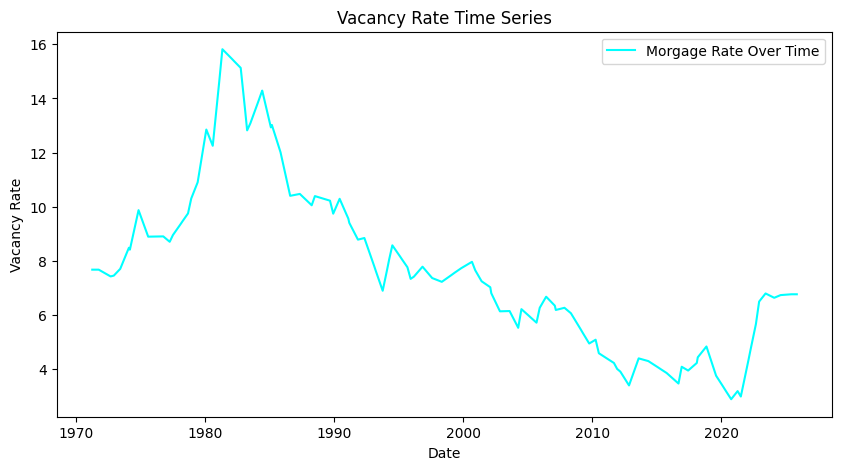

ADF Statistic (differenced): -5.630647804921188
p-value (differenced): 1.0914918932942654e-06
Critical Value (1%): -3.441
Critical Value (5%): -2.866
Critical Value (10%): -2.569
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Nov, 2025
Time:                     11:55:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.1917
Nobs:                     641.000    HQIC:                  -12.3877
Log likelihood:           2237.01    FPE:                3.68247e-06
AIC:                     -12.5120    Det(Omega_mle):     3.43177e-06
--------------------------------------------------------------------
Results for equation real_prices_diff
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const           

In [50]:
# import morgage_rate data
morgage_rate = pd.read_excel(data_path / "MORTGAGE30US.xlsx", sheet_name="Weekly, Ending Thursday")
morgage_rate = morgage_rate.set_index("observation_date")
# change column name to 'morgage_rate'
morgage_rate.rename(columns={"MORTGAGE30US": "morgage_rate"}, inplace=True)

# convert weekly to monthly
morgage_rate_monthly = morgage_rate.resample('MS').interpolate(method='linear').ffill().bfill()
# plot morgage rate
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(morgage_rate_monthly.index, morgage_rate_monthly.morgage_rate, label='Morgage Rate Over Time', color='cyan')
plt.xlabel('Date')      
plt.ylabel('Vacancy Rate')
plt.title('Vacancy Rate Time Series')
plt.legend()
plt.show()
# difference vacancy rate to make it stationary
morgage_rate_monthly_diff = morgage_rate_monthly.diff().dropna()
adf_result_vr = adfuller(morgage_rate_monthly_diff.morgage_rate)
print('ADF Statistic (differenced):', adf_result_vr[0])
print('p-value (differenced):', adf_result_vr[1])
for key, value in adf_result_vr[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

# redo the VAR model with vacancy rate
log_real_prices_diff = pd.Series(log_real_prices).diff().dropna()
data_combined_diff = pd.DataFrame({
    'real_prices_diff': log_real_prices_diff,
    'morgage_rate_diff': morgage_rate_monthly_diff.morgage_rate.reindex(prices.observation_date)  # Align vacancy rate to prices index
})
data_combined_diff = data_combined_diff.dropna()
# use var 3 model
results = VAR(data_combined_diff).fit(maxlags=15, ic='aic')
print(results.summary())    

In [51]:
# import /Users/aleksandrazografska/Downloads/CSUSHPISA.xlsx data
home_sales = pd.read_excel(data_path / "CSUSHPISA.xlsx", sheet_name="Monthly")
home_sales = home_sales.set_index("observation_date") 
home_sales = home_sales.rename(columns={"CSUSHPISA": "home_sales"})
# difference home sales to make it stationary
home_sales_diff = home_sales.home_sales.diff().dropna()
adf_result_hs = adfuller(home_sales_diff)
print('ADF Statistic (differenced):', adf_result_hs[0])
print('p-value (differenced):', adf_result_hs[1])
for key, value in adf_result_hs[4].items():
    print('Critical Value (%s): %.3f' % (key, value))
    
# redo the VAR model with home sales and mortgage rate
log_real_prices_diff = pd.Series(log_real_prices).diff().dropna()
data_combined_diff = pd.DataFrame({
 # Align vacancy rate to prices index
    'home_sales_diff': home_sales_diff,
    'morgage_rate_diff': morgage_rate_monthly_diff.morgage_rate.reindex(home_sales_diff.index), # Align home sales to prices index
})
data_combined_diff = data_combined_diff.dropna()
# use var 3 model
results = VAR(data_combined_diff).fit(maxlags=15, ic='aic')
print(results.summary())

ADF Statistic (differenced): -3.4201398368853093
p-value (differenced): 0.010291168974405504
Critical Value (1%): -3.445
Critical Value (5%): -2.868
Critical Value (10%): -2.570
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Nov, 2025
Time:                     11:55:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.77415
Nobs:                     449.000    HQIC:                  -8.09556
Log likelihood:           648.194    FPE:                0.000247446
AIC:                     -8.30468    Det(Omega_mle):     0.000218332
--------------------------------------------------------------------
Results for equation home_sales_diff
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const             

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



STEP 2: STANDARDIZATION

Features standardized (mean=0, std=1)
Training set shape: (343, 4)
Test set shape: (86, 4)

STEP 3: PCA FACTOR ANALYSIS

Explained variance by each component:
  PC1: 0.2806 (28.06%)
  PC2: 0.2684 (26.84%)
  PC3: 0.2639 (26.39%)
  PC4: 0.1871 (18.71%)

Cumulative explained variance:
  PC1-PC1: 0.2806 (28.06%)
  PC1-PC2: 0.5490 (54.90%)
  PC1-PC3: 0.8129 (81.29%)
  PC1-PC4: 1.0000 (100.00%)

PCA Loadings (Component Matrix):
                     PC1    PC2    PC3    PC4
loans_diff         0.628 -0.471 -0.323 -0.529
net_wealth_diff    0.224  0.219  0.841 -0.441
vacancy_rate_diff  0.744  0.369 -0.002  0.557
morgage_rate_diff -0.036  0.771 -0.434 -0.465

STEP 4: DETERMINE NUMBER OF FACTORS

Eigenvalues:
  PC1: 1.1259 ✓ (Keep)
  PC2: 1.0766 ✓ (Keep)
  PC3: 1.0587 ✓ (Keep)
  PC4: 0.7505   (Drop)

Kaiser criterion suggests keeping 3 component(s)
To explain 80.0% variance: 3 component(s)

STEP 5: REGRESSION WITH PRINCIPAL COMPONENTS

Using 3 principal component(s) for r

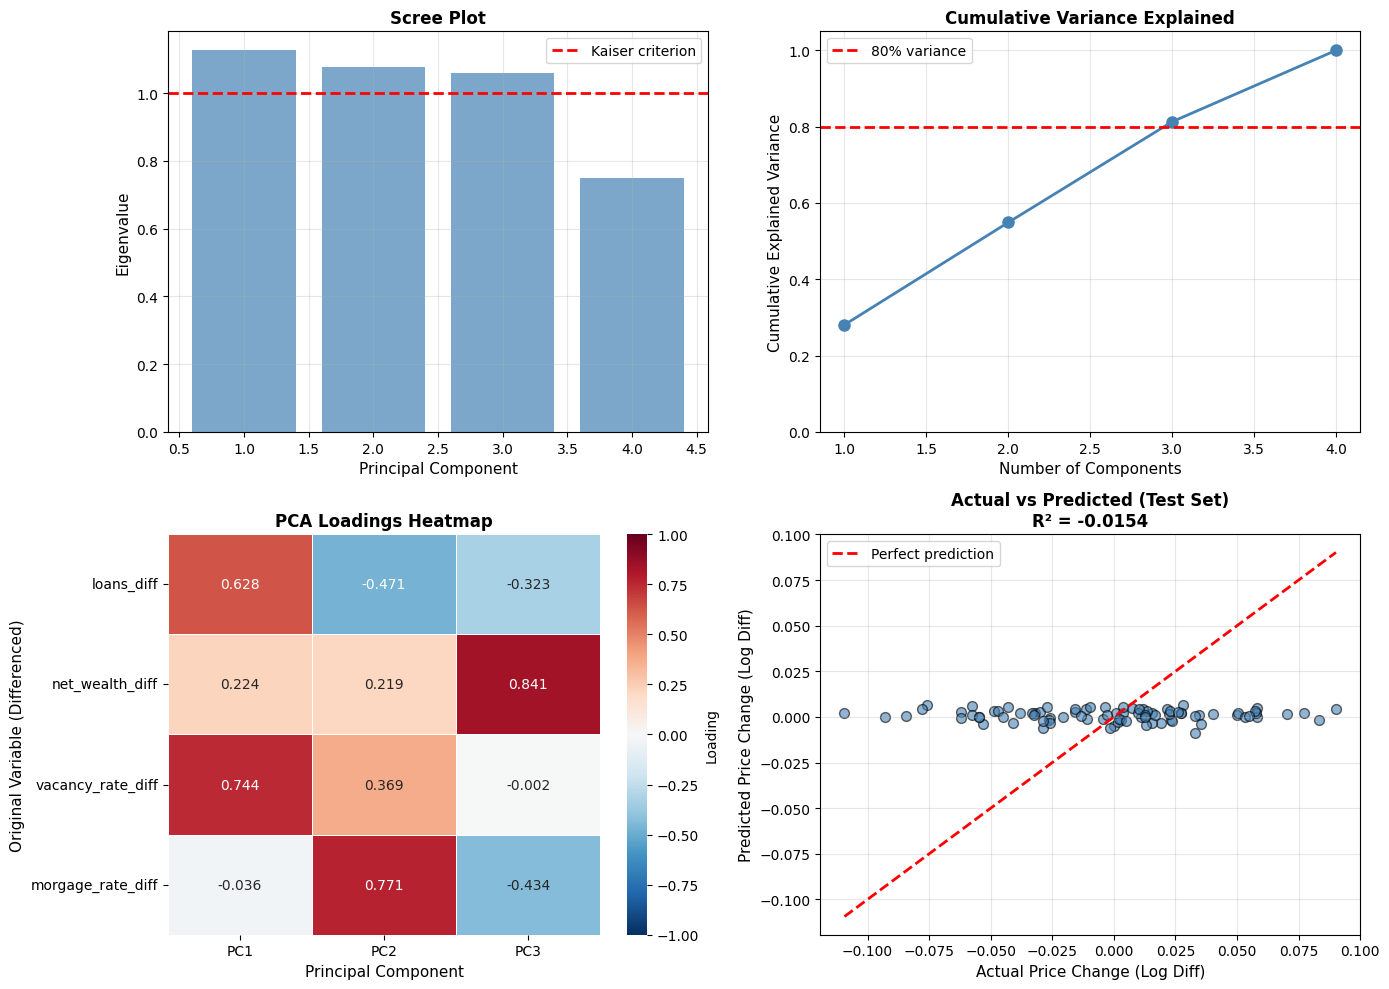


ANALYSIS COMPLETE

Note: You're modeling CHANGES in log prices using CHANGES in predictors.
This is appropriate for non-stationary time series data.


In [57]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
# Combine all variables into a single DataFrame
data = pd.DataFrame({
    'real_prices_diff': log_real_prices_diff,
    'loans_diff': loans_diff.reindex(prices.observation_date),  # Align loans to prices index
    'net_wealth_diff': net_wealth_diff.reindex(prices.observation_date),  # Align net wealth to prices index
    'vacancy_rate_diff': vacancy_rate_monthly_diff.vacancy_rate.reindex(prices.observation_date),  # Align vacancy rate to prices index
    'morgage_rate_diff': morgage_rate_monthly_diff.morgage_rate.reindex(prices.observation_date)  # Align morgage rate to prices index
})
data = data.dropna()
X = data[['loans_diff', 'net_wealth_diff', 'vacancy_rate_diff', 'morgage_rate_diff']]
y = data['real_prices_diff']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("\n" + "=" * 60)
print("STEP 2: STANDARDIZATION")
print("=" * 60)
# Standardize features (required for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures standardized (mean=0, std=1)")
print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

print("\n" + "=" * 60)
print("STEP 3: PCA FACTOR ANALYSIS")
print("=" * 60)

# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display explained variance
print("\nExplained variance by each component:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%)")

print(f"\nCumulative explained variance:")
cumsum = np.cumsum(pca.explained_variance_ratio_)
for i, var in enumerate(cumsum, 1):
    print(f"  PC1-PC{i}: {var:.4f} ({var*100:.2f}%)")

# Component loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i}' for i in range(1, len(pca.components_) + 1)],
    index=X.columns
)
print("\nPCA Loadings (Component Matrix):")
print(loadings.round(3))

print("\n" + "=" * 60)
print("STEP 4: DETERMINE NUMBER OF FACTORS")
print("=" * 60)

# Kaiser criterion: eigenvalues > 1
eigenvalues = pca.explained_variance_
print("\nEigenvalues:")
for i, ev in enumerate(eigenvalues, 1):
    print(f"  PC{i}: {ev:.4f}", "✓ (Keep)" if ev > 1 else "  (Drop)")

n_components_kaiser = sum(eigenvalues > 1)
print(f"\nKaiser criterion suggests keeping {n_components_kaiser} component(s)")

# Choose based on variance threshold (e.g., 80%)
variance_threshold = 0.80
n_components_var = np.argmax(cumsum >= variance_threshold) + 1
print(f"To explain {variance_threshold*100}% variance: {n_components_var} component(s)")

print("\n" + "=" * 60)
print("STEP 5: REGRESSION WITH PRINCIPAL COMPONENTS")
print("=" * 60)

# Use the number of components that explain ~80-90% variance
n_final = max(n_components_kaiser, n_components_var)
print(f"\nUsing {n_final} principal component(s) for regression")

X_train_pca_reduced = X_train_pca[:, :n_final]
X_test_pca_reduced = X_test_pca[:, :n_final]

# Fit regression model
model = LinearRegression()
model.fit(X_train_pca_reduced, y_train)

# Predictions
y_train_pred = model.predict(X_train_pca_reduced)
y_test_pred = model.predict(X_test_pca_reduced)

# Evaluate
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nModel Performance:")
print(f"  Training R²: {train_r2:.4f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Training RMSE: {train_rmse:.6f}")
print(f"  Test RMSE: {test_rmse:.6f}")
print(f"  Training MAE: {train_mae:.6f}")
print(f"  Test MAE: {test_mae:.6f}")

print("\nRegression Coefficients (for PCs):")
for i, coef in enumerate(model.coef_, 1):
    print(f"  PC{i}: {coef:.4f}")
print(f"  Intercept: {model.intercept_:.6f}")

# Interpretation: Map PC coefficients back to original variables
print("\n" + "=" * 60)
print("INTERPRETATION: Effect on Price Changes")
print("=" * 60)
print("\nApproximate contribution of original variables:")
print("(PC coefficients × loadings)")

original_effects = np.dot(loadings.iloc[:, :n_final], model.coef_)
for var, effect in zip(X.columns, original_effects):
    print(f"  {var}: {effect:.4f}")

print("\n" + "=" * 60)
print("STEP 6: VISUALIZATION")
print("=" * 60)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scree plot
axes[0, 0].bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7, color='steelblue')
axes[0, 0].axhline(y=1, color='r', linestyle='--', label='Kaiser criterion', linewidth=2)
axes[0, 0].set_xlabel('Principal Component', fontsize=11)
axes[0, 0].set_ylabel('Eigenvalue', fontsize=11)
axes[0, 0].set_title('Scree Plot', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Cumulative variance explained
axes[0, 1].plot(range(1, len(cumsum) + 1), cumsum, marker='o', linewidth=2, 
                color='steelblue', markersize=8)
axes[0, 1].axhline(y=0.8, color='r', linestyle='--', label='80% variance', linewidth=2)
axes[0, 1].set_xlabel('Number of Components', fontsize=11)
axes[0, 1].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[0, 1].set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1.05])

# 3. Component loadings heatmap
sns.heatmap(loadings.iloc[:, :n_final], annot=True, cmap='RdBu_r', center=0, 
            ax=axes[1, 0], cbar_kws={'label': 'Loading'}, fmt='.3f',
            vmin=-1, vmax=1, linewidths=0.5)
axes[1, 0].set_title('PCA Loadings Heatmap', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Principal Component', fontsize=11)
axes[1, 0].set_ylabel('Original Variable (Differenced)', fontsize=11)

# 4. Actual vs Predicted
axes[1, 1].scatter(y_test, y_test_pred, alpha=0.6, color='steelblue', 
                   edgecolors='black', s=50)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, 
                label='Perfect prediction')
axes[1, 1].set_xlabel('Actual Price Change (Log Diff)', fontsize=11)
axes[1, 1].set_ylabel('Predicted Price Change (Log Diff)', fontsize=11)
axes[1, 1].set_title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.4f}', 
                     fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_analysis_results.png', dpi=300, bbox_inches='tight')
print("\nVisualizations saved as 'pca_analysis_results.png'")
plt.show()

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
print("\nNote: You're modeling CHANGES in log prices using CHANGES in predictors.")
print("This is appropriate for non-stationary time series data.")